# 0. Overview

This notebook is created to perform data analysis for the covid spread in Allegheny County, Pennsylvania over the period of 1 feb 2020 to 1 october 2021. 

# 1. Data Extraction

### 1.1 Importing Libraries
In this section I am loading the important libraries that will be needed for the data analysis. 

In [1]:
# !pip install ruptures

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ruptures as rpt

import warnings
warnings.filterwarnings("ignore")

### 1.2 Data Extraction

In [3]:
# loading RAW_us_confirmed_cases.csv 
confirmed_cases_data = pd.read_csv("RAW_us_confirmed_cases.csv")
confirmed_cases_data.shape

(3342, 1025)

In [4]:
# loading RAW_us_death_cases.csv 
death_data = pd.read_csv("RAW_us_deaths.csv")
death_data.shape

(3342, 1028)

In [5]:
# loading the CDC dataset of masking mandates by county
mask_mandate_data = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")
mask_mandate_data.shape

(1593869, 10)

In [6]:
# loading the New York Times mask compliance survey data
mask_use_data = pd.read_csv("mask-use-by-county.csv")
mask_use_data.shape

(3142, 6)

# 2 Data Selection and Preprocessing

Since this notebook will deal with analysing the data from Pennsylvania only, specifically county Allegheny, in this section I am creating a subset of relevant data needed for furhter analyis.

### 2.1 Confirmed Cases

In [7]:
# storing FIPS values
FIPS_County_Allegheny = 42003

In [10]:
# selecting specific county 
confirmed_cases_subset = confirmed_cases_data.loc[(confirmed_cases_data['Province_State'] == 'Pennsylvania') & 
                        (confirmed_cases_data['Admin2'] == 'Allegheny')]
# dropping not required columns
confirmed_cases_subset.drop(['iso2', 'iso3', 'Country_Region', 'Lat' , 'Long_', 'Combined_Key', 'Admin2', 'UID',
                          'Province_State','code3', 'FIPS'], axis = 1, inplace = True)
confirmed_cases_subset

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
2332,0,0,0,0,0,0,0,0,0,0,...,321509,321509,321509,321509,322504,322504,322504,322504,322504,322504


In [12]:
# pivot data
confirmed_cases_subset_unpivoted = confirmed_cases_subset.melt(var_name='date', value_name='confirmed_cases')
confirmed_cases_subset_unpivoted['date'] = pd.to_datetime(confirmed_cases_subset_unpivoted['date'], 
                                                          format = '%m/%d/%y')

### 2.2 Count of Death

In [17]:
# selecting subset
death_data_subset = death_data.loc[(death_data['Province_State'] == 'Pennsylvania') & 
                        (death_data['Admin2'] == 'Allegheny')]

# dropping not required columns
death_data_subset.drop(['iso2', 'iso3', 'Country_Region', 'Lat' , 'Long_', 'Combined_Key', 'Population', 'Admin2',
                          'UID','Province_State', 'code3', 'FIPS'], axis = 1, inplace = True)
death_data_subset

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22,11/2/22
2332,0,0,0,0,0,0,0,0,0,0,...,3583,3583,3595,3595,3595,3595,3595,3595,3595,3607


In [18]:
# pivot data
death_subset_unpivoted = death_data_subset.melt(var_name='date', value_name='death')
death_subset_unpivoted['date'] = pd.to_datetime(death_subset_unpivoted['date'], format = '%m/%d/%y')

### 2.3 Mask Mandate Data

In [20]:
# creating subset
mask_mandate_subset = mask_mandate_data.loc[(mask_mandate_data['State_Tribe_Territory'] == 'PA') & 
                                          (mask_mandate_data['County_Name'] == 'Allegheny County')]

# dropping not required columns
mask_mandate_subset.drop(['State_Tribe_Territory', 'FIPS_State', 'FIPS_County', 'URL', 'order_code',
                         'County_Name', 'Source_of_Action', 'Citation'], 
                         axis=1, inplace = True)
mask_mandate_subset['date'] = pd.to_datetime(mask_mandate_subset['date'], format = '%m/%d/%Y')

In [21]:
mask_mandate_subset.isnull().sum()

date                             0
Face_Masks_Required_in_Public    9
dtype: int64

In [22]:
# there is no information for the first 9 dates
# since default assumption is no mask, these values are set to no
mask_mandate_subset['Face_Masks_Required_in_Public'].fillna('No', inplace=True)

### 2.4 mask_use_data

In [23]:
mask_use_data_subset = mask_use_data.loc[mask_use_data['COUNTYFP'] == FIPS_County_Allegheny]

### 2.5 Combining datasets
All the subsets are now combined in this section for further analysis

In [24]:
# merging confirmed_cases and mask_mandate
AlleghenyCounty_data = pd.merge(left = confirmed_cases_subset_unpivoted[['date', 'confirmed_cases']], 
                                right = mask_mandate_subset[['date','Face_Masks_Required_in_Public']],
                               on = 'date', how = 'left')

# merging previous dataframe and death_data
AlleghenyCounty_data= pd.merge(left = AlleghenyCounty_data, 
                                right = death_subset_unpivoted[['date','death']],
                               on = 'date', how = 'left')

### 2.6 Data Preprocessing

In [25]:
# this is what the data looks like
AlleghenyCounty_data.head()

,date,confirmed_cases,Face_Masks_Required_in_Public,death
0,2020-01-22,0,NaN,0
1,2020-01-23,0,NaN,0
2,2020-01-24,0,NaN,0
3,2020-01-25,0,NaN,0
4,2020-01-26,0,NaN,0


* Deal with missing values in Face_Masks_Required_in_Public column
* Add a new column for current population based on the deaths occured 

In [87]:
AlleghenyCounty_data['current_population'] = 0
AlleghenyCounty_data['current_population'][0] = 1250578 

In [88]:
for i in range(1, len(AlleghenyCounty_data)):
    AlleghenyCounty_data['current_population'][i] = AlleghenyCounty_data['current_population'][i-1] - AlleghenyCounty_data['death'][i]
    

In [89]:
# some dates are not available in mask mandate data and joining dataframe returns missing value for these dates
# replacing these missing nan with 'unknown' so it can be ussed for analysis
AlleghenyCounty_data['Face_Masks_Required_in_Public'].fillna('unknown', inplace=True)

In [90]:
AlleghenyCounty_data.head()

,date,confirmed_cases,Face_Masks_Required_in_Public,death,current_population
0,2020-01-22,0,unknown,0,1250578
1,2020-01-23,0,unknown,0,1250578
2,2020-01-24,0,unknown,0,1250578
3,2020-01-25,0,unknown,0,1250578
4,2020-01-26,0,unknown,0,1250578


In [91]:
# selecting data from 1 feb 2020 to 1 oct 2021 for analysis
AlleghenyCounty_data_feb_oct = AlleghenyCounty_data.loc[(AlleghenyCounty_data['date']>='2020-02-01') & 
                                (AlleghenyCounty_data['date']<='2021-10-01')]

In [92]:
# adding a new column to track change in infection
AlleghenyCounty_data_feb_oct['change_in_daily_cases'] = AlleghenyCounty_data_feb_oct['confirmed_cases'] - AlleghenyCounty_data_feb_oct['confirmed_cases'].shift(1)

# 3. Data Analysis

### 3.1 Confirmed cases over time
Displaying a plot for how number of cases have changed over time. The hue for this plot shows what was the status of mask mandate on the given day.

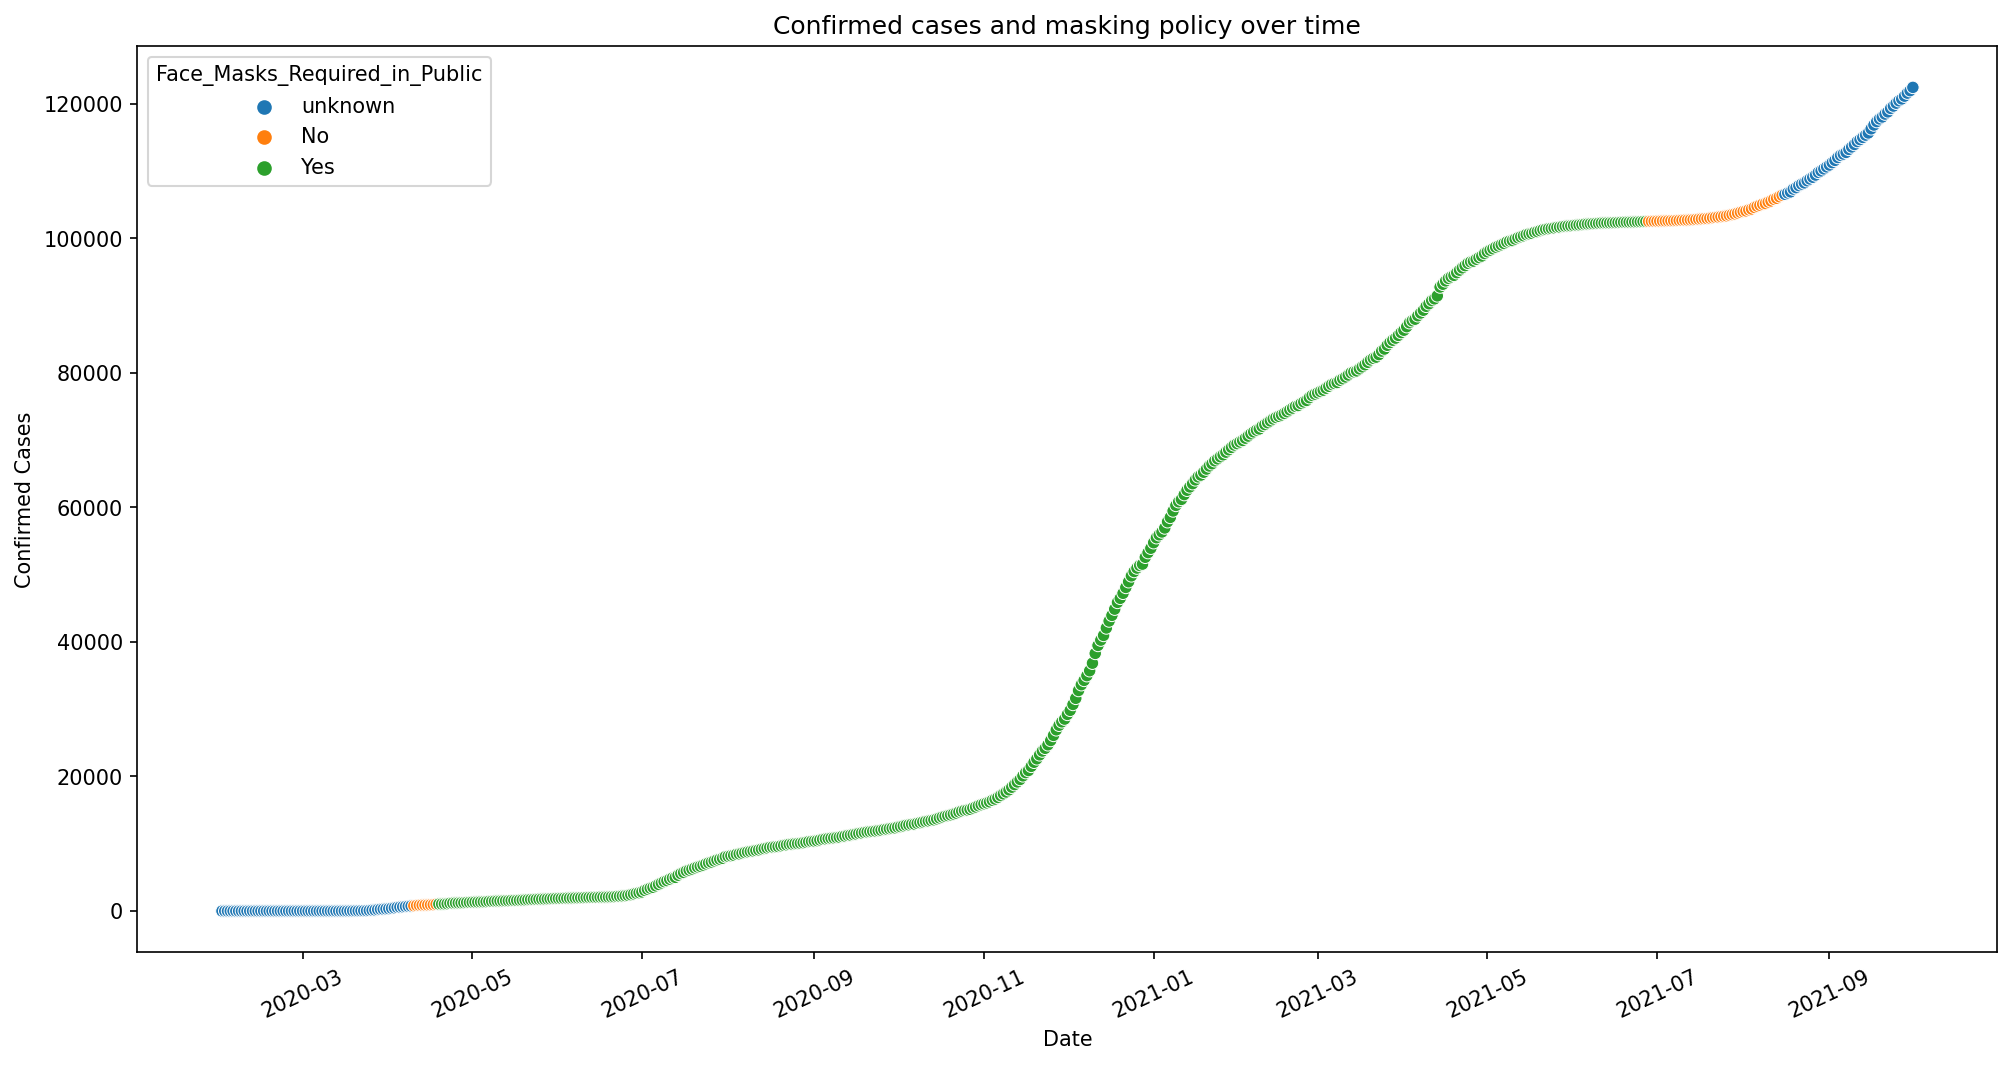

In [105]:
# create the time series plot for confirmed cases over time
plt.figure(figsize=(16,8), dpi = 150)
sns.scatterplot(x = "date", y = "confirmed_cases", data = AlleghenyCounty_data_feb_oct,  
                hue='Face_Masks_Required_in_Public')

plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed cases and masking policy over time')
plt.xticks(rotation = 25)
plt.savefig('masking_policy_vs_confirmed_cases.jpeg')
plt.show()

### 3.2 Change points over time

In [94]:
# Detect the change points
algo1 = rpt.Pelt(model="rbf").fit(np.array(AlleghenyCounty_data_feb_oct['confirmed_cases']))
change_location1 = algo1.predict(pen=10)

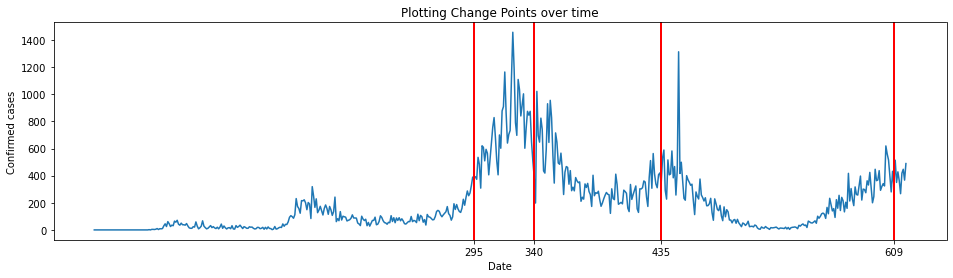

In [95]:
plt.figure(figsize=(16,4))
plt.plot(AlleghenyCounty_data_feb_oct['change_in_daily_cases'])
for x in change_location1:
        plt.axvline(x,lw=2, color='red')
plt.xticks(change_location1)
plt.title('Plotting Change Points over time')
plt.xlabel("Date")
plt.ylabel("Confirmed cases")
plt.show()

# 4. Final Visualization

Objective - create a time series showing the changes in the derivative function of the rate of infection. 

**What is rate of infection?**

The rate of infection is defined as 
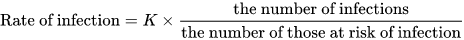


where k is a constant
Source: https://en.wikipedia.org/wiki/Infection_rate

In [101]:
# calculating rate of infection
AlleghenyCounty_data_feb_oct['rate_of_infection'] = (AlleghenyCounty_data_feb_oct['confirmed_cases']/AlleghenyCounty_data_feb_oct['current_population'])
# calculating derivative of rate of infection
AlleghenyCounty_data_feb_oct['change_rate_of_infection'] = AlleghenyCounty_data_feb_oct['rate_of_infection'] - AlleghenyCounty_data_feb_oct['rate_of_infection'].shift(1)

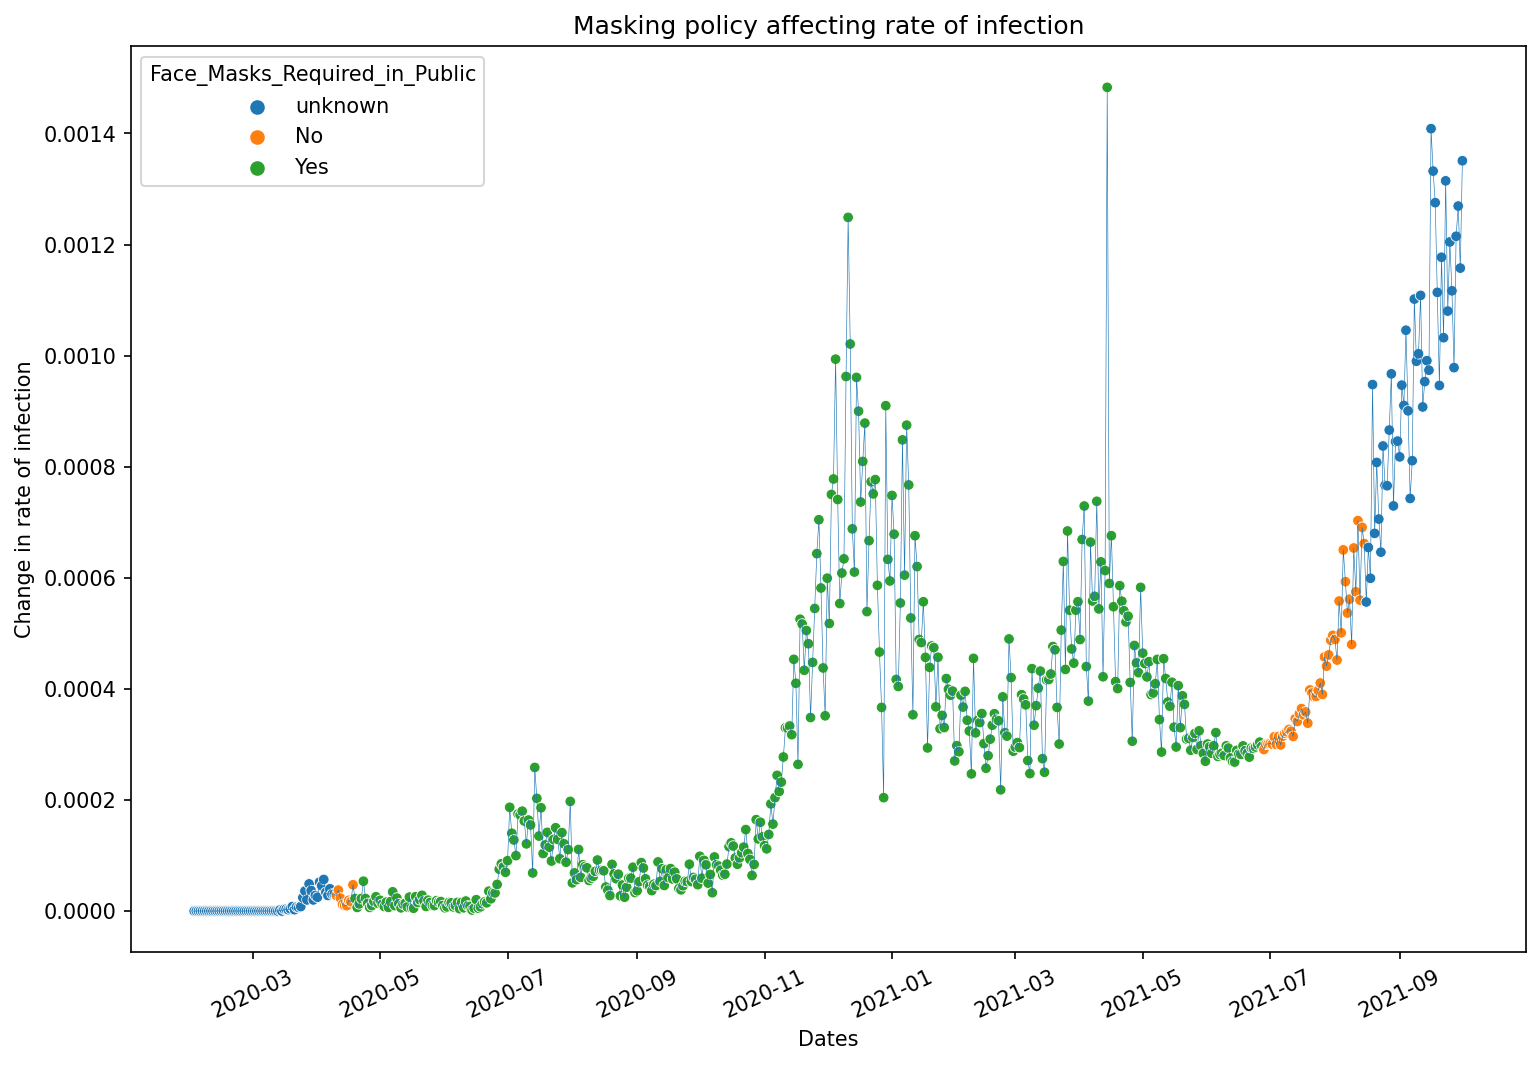

In [104]:
# create the time series plot for masking policy and change in rate of infection
plt.figure(figsize=(12,8), dpi = 150)
sns.lineplot(x = "date", y = "change_rate_of_infection", data = AlleghenyCounty_data_feb_oct, linewidth = 0.3)
sns.scatterplot(x = "date", y = "change_rate_of_infection", data = AlleghenyCounty_data_feb_oct,  
                hue='Face_Masks_Required_in_Public', s = 26)

plt.xlabel('Dates')
plt.ylabel('Change in rate of infection')
plt.title('Masking policy affecting rate of infection')
plt.xticks(rotation = 25)
plt.savefig('masking_policy_vs_infection_rate.jpeg')
plt.show()